# 1. Pre-processing

### Libraries

In [1]:
import sys
sys.path.append('..')
from _utils.BattLeDIM_utils import *

### Data loading

In [2]:
scada_data = SCADA_data()
path_scada = '../_utils/Data/SCADA_data/2019/'

scada_data.load(path_scada)

### General information

In [3]:
dct_n2dma = dict({'DMA_A':['n54','n105','n114','n163','n188','n288','n296',
                           'n332','n342','n410','n415','n429','n458','n469',
                           'n495','n506','n516','n519','n549','n613','n636',
                           'n644','n679','n722', 'n726','n740','n752','n769'],
                  'DMA_B':['n215','n229'],
                  'DMA_C':['n1','n4','n31'],
                  'AMR_n':['n1','n2','n3','n4','n6','n7','n8','n9','n10','n11','n13',
                           'n16','n17','n18','n19','n20','n21','n22','n23','n24','n25',
                           'n26','n27','n28','n29','n30','n31','n32','n33','n34','n35',
                           'n36','n39','n40','n41','n42','n43','n44','n45',
                           'n343','n344','n345','n346','n347','n349','n350','n351','n352',
                           'n353','n354','n355','n356','n357','n358','n360','n361','n362',
                           'n364','n365','n366','n367','n368','n369','n370','n371','n372',
                           'n373','n374','n375','n376','n377','n378','n379','n381','n382',
                           'n383','n384','n385','n386','n387','n388','n389']})

In [4]:
sampling_rate='5min'

### Ground truth

In [5]:
path_ground_truth = '../_utils/Data/leak_ground_truth/'
leak_signals = pd.read_csv('{}2019_Leakages.csv'.format(path_ground_truth),sep=';',decimal=',',parse_dates=['Timestamp'])
leak_signals.index = leak_signals['Timestamp'].values
leak_signals = leak_signals.drop(['Timestamp'],axis=1)

### Results

In [6]:
trajectories = pd.DataFrame(dtype=float)

# 2. Analysis

In [7]:
def leak_analysis(nodes):
    N = len(nodes)
    T = scada_data.pressures.shape[0]
    P = scada_data.pressures[nodes].values
    V = scada_data.flows['PUMP_1'].values
    
    K0 = np.zeros((N,N))
    K1 = np.zeros((N,N))
    Kd = np.zeros((N,N))
    
    ref_nodes = []
    for i,node in enumerate(nodes):
        ref_node = Ref_node(node)
        models=[]

        X_tr = np.concatenate([scada_data.pressures[node].loc[cor_time_frame[0]:cor_time_frame[1]].to_numpy().reshape(-1,1),
                               scada_data.flows['PUMP_1'].loc[cor_time_frame[0]:cor_time_frame[1]].to_numpy().reshape(-1,1)],
                             axis=1)

        for j,node_cor in enumerate(nodes):
            y_tr = scada_data.pressures[node_cor].loc[cor_time_frame[0]:cor_time_frame[1]].to_numpy().reshape(-1,1)
            model = LinearRegression()
            models.append(model.fit(X_tr, y_tr))
            K0[i,j] = model.intercept_[0]
            K1[i,j] = model.coef_[0][0]
            Kd[i,j] = model.coef_[0][1]
        ref_node.set_models(models)
    
    np.fill_diagonal(K0,0)
    np.fill_diagonal(K1,1)
    np.fill_diagonal(Kd,0)
    
    e = np.multiply.outer(K0,np.ones(T))\
        + np.multiply.outer(Kd,V)\
        + np.multiply.outer(K1,np.ones(T))*np.multiply.outer(P,np.ones(N)).transpose(1,2,0)\
        - np.multiply.outer(P,np.ones(N)).transpose(2,1,0)
    
    if 'n215' in nodes:
        e[nodes.index('n215'),:,:] *= 0.02
    
    res = np.zeros((N,T))
    for t in range(T):
        e_t_i = e[:,:,t].copy()
        e_t_i[e_t_i<0]=0
        e_t_i[e_t_i>0]=1
        i_ = pd.Series(e_t_i.sum(axis=0)).sort_values(ascending=False).index.to_list()
        i_max = int(i_[0])
        
        res[i_max,t] = np.linalg.norm(e[:,:,t][:,i_max])
            
    plt.style.use(['default'])
    f,ax = plt.subplots(1,sharex=True,sharey=True,figsize=(18,7))
    locator = mdates.AutoDateLocator(minticks=7, maxticks=15)
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.offset_formats[2] = '%Y'

    MRE = pd.DataFrame(res.T,index=scada_data.pressures.index,columns=nodes)
    for i,node in enumerate(nodes):
        ax.plot(MRE[node],label=node,color=plt.get_cmap('gist_ncar')(i/N))

    ax.set_ylabel('$\Vert MRE_{s}(t) \Vert_F$',fontsize=24)
    ax.legend(prop={'size': 24},loc=6,ncol=2,bbox_to_anchor=(1.02, 0.5))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    f.tight_layout()
    plt.show()
    
def leak_analysis_individual():
    states = []
    for time_frame in time_frame_list:
        states.append(State(start=time_frame[0],end=time_frame[3],cor_start=time_frame[1],cor_end=time_frame[2]))

    for state in states:
        models=[]
        cor_time_frame = [state._cor_start,state._cor_end]

        X_tr = np.concatenate([scada_data.pressures[node_MAS].loc[cor_time_frame[0]:cor_time_frame[1]].to_numpy().reshape(-1,1),
                               scada_data.flows['PUMP_1'].loc[cor_time_frame[0]:cor_time_frame[1]].to_numpy().reshape(-1,1)],
                             axis=1)

        for node_cor in scada_data.pressures.columns.to_numpy():
            y_tr = scada_data.pressures[node_cor].loc[cor_time_frame[0]:cor_time_frame[1]].to_numpy().reshape(-1,1)
            model = LinearRegression()
            models.append(model.fit(X_tr, y_tr))
        state.set_models(models)

    df_state = pd.DataFrame(np.zeros((scada_data.pressures.shape[0],scada_data.pressures.shape[1])),
                            columns=scada_data.pressures.columns,
                            index=scada_data.pressures.index)

    for i_ in range(len(states)):
        models = states[i_]._models_Reg
        start = states[i_]._start
        end = states[i_]._end

        for node_cor in closest_nodes:
            df_error = pd.DataFrame(index=scada_data.pressures.index)

            y_test = scada_data.pressures[node_cor].to_numpy().reshape(-1,1)
            X_test = np.concatenate([scada_data.pressures[node_MAS].to_numpy().reshape(-1,1),
                                     scada_data.flows['PUMP_1'].to_numpy().reshape(-1,1)],
                                   axis=1)

            df_error['e'] = y_test - models[scada_data.pressures.columns.tolist().index(node_cor)].predict(X_test)
            df_state[node_cor].loc[start:end] = df_error['e'].loc[start:end]

    f,ax = plt.subplots(1,sharex=True,figsize=(9,6))
    locator = mdates.AutoDateLocator(minticks=7, maxticks=15)
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.offset_formats[2] = '%Y'
    ax.get_xaxis().set_major_locator(locator)
    ax.get_xaxis().set_major_formatter(formatter)

    for node_cor in closest_nodes:
        ax.plot(df_state[node_cor],label=node_cor)

    ax.set_xlim(pd.to_datetime(time_frame_list[0][0]),pd.to_datetime(time_frame_list[-1][-1]))
    ax.legend(loc=0,prop={'size': 16})
    ax.set_ylabel('MRE',fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    f.tight_layout()
    plt.show()

    trajectories[pipe_id] = df_state[closest_nodes[0]]

### General analysis

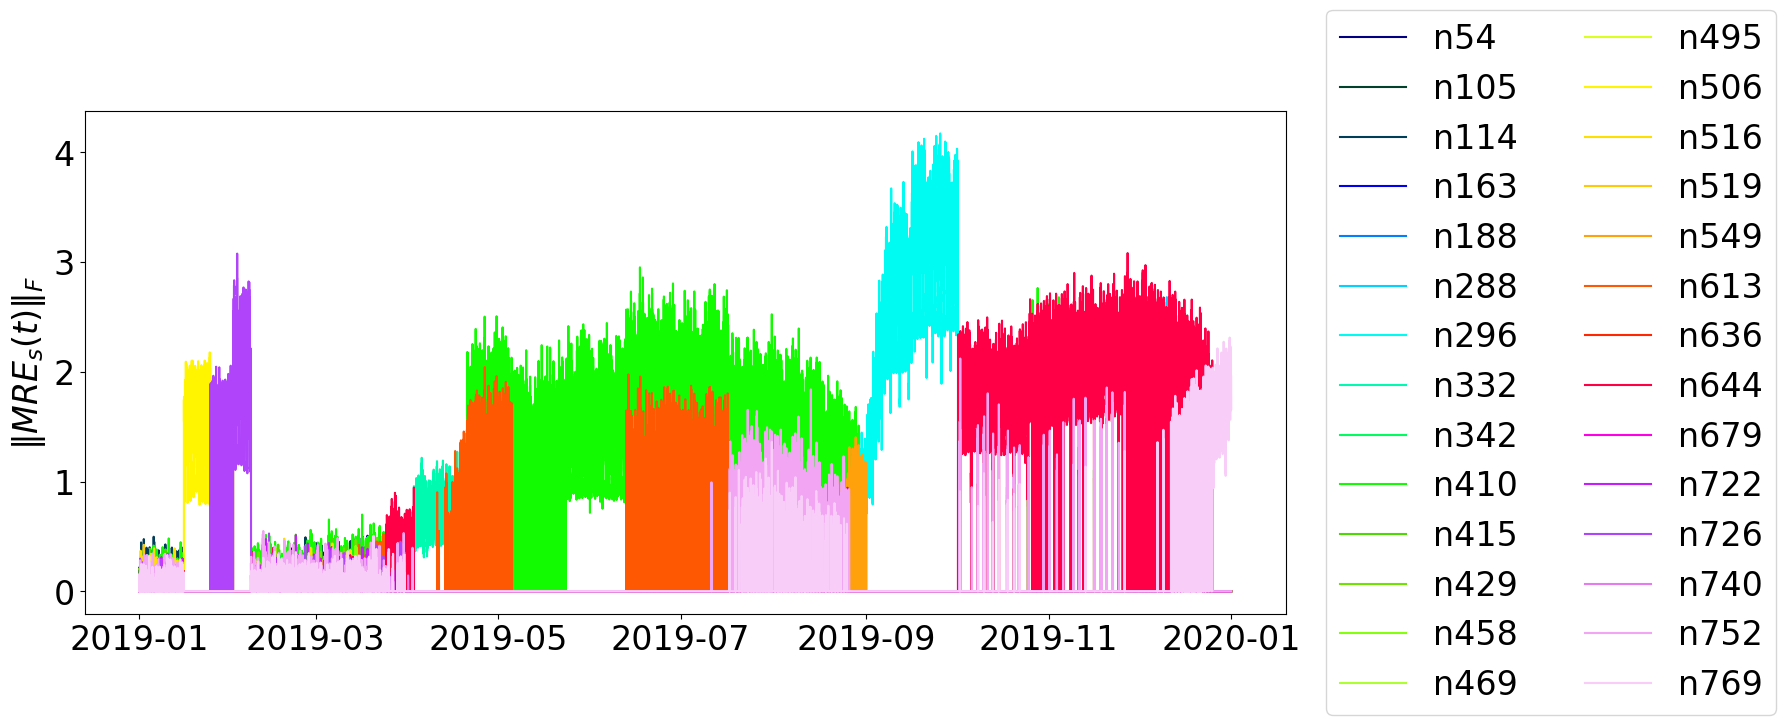

In [8]:
cor_time_frame = ['2019-01-01 00:00','2019-01-10 00:00']
leak_analysis(dct_n2dma['DMA_A'])

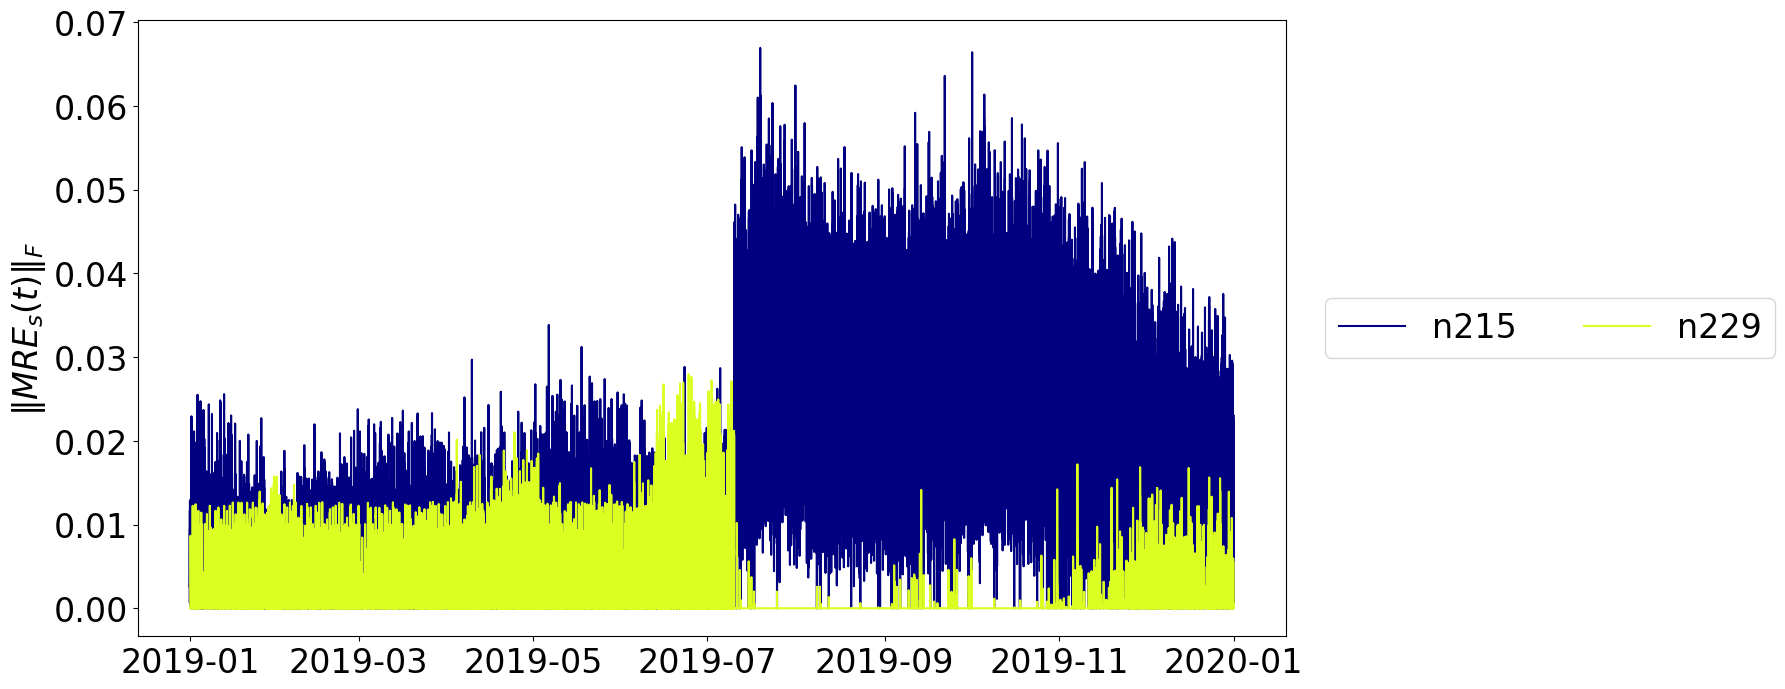

In [9]:
cor_time_frame = ['2019-06-15 00:00','2019-06-30 00:00']
leak_analysis(dct_n2dma['DMA_B'])

### Leak 1

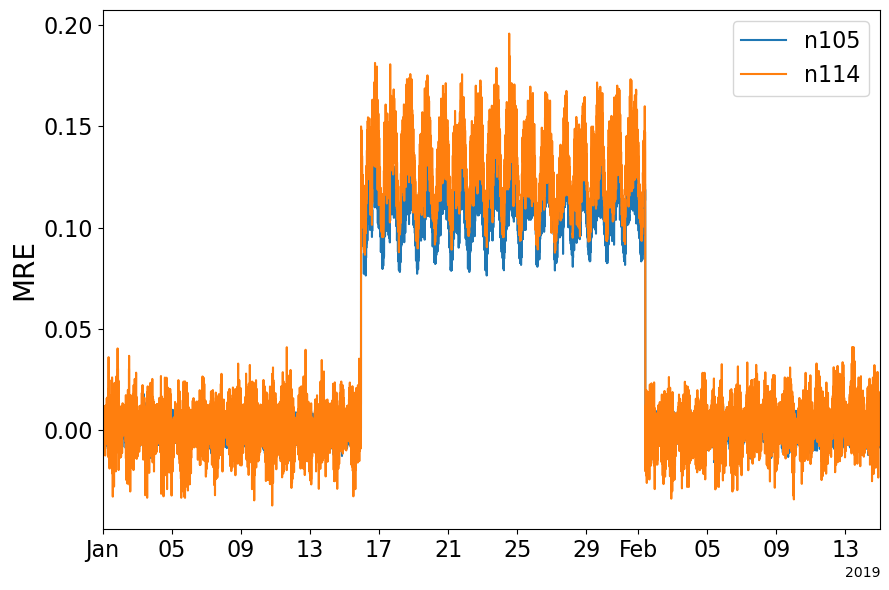

In [10]:
node_MAS = 'n506'
closest_nodes = ['n105','n114']
pipe_id = 'p523'

time_frame_list = [['2019-01-01 00:00','2019-01-05 00:00','2019-01-09 00:00','2019-01-24 18:25'], 
                   ['2019-01-24 18:30','2019-02-03 00:00','2019-02-06 00:00','2019-02-07 09:05'], 
                   ['2019-02-07 09:10','2019-01-05 00:00','2019-01-09 00:00','2019-02-15 00:00']]
leak_analysis_individual()

### Leak 2

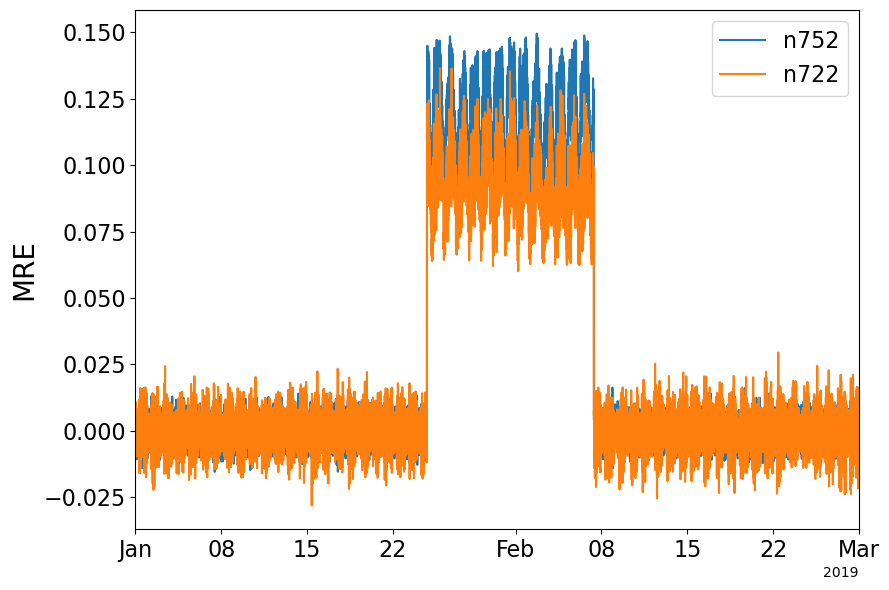

In [11]:
node_MAS = 'n726'
closest_nodes = ['n752','n722']
pipe_id = 'p827'

time_frame_list = [['2019-01-01 00:00','2019-01-05 00:00','2019-01-09 00:00','2019-01-15 22:55'],
                   ['2019-01-15 23:00','2019-01-18 00:00','2019-01-20 00:00','2019-02-01 09:50'],
                   ['2019-02-01 09:55','2019-01-05 00:00','2019-01-09 00:00','2019-03-01 00:00']]
leak_analysis_individual()

### Leak 3

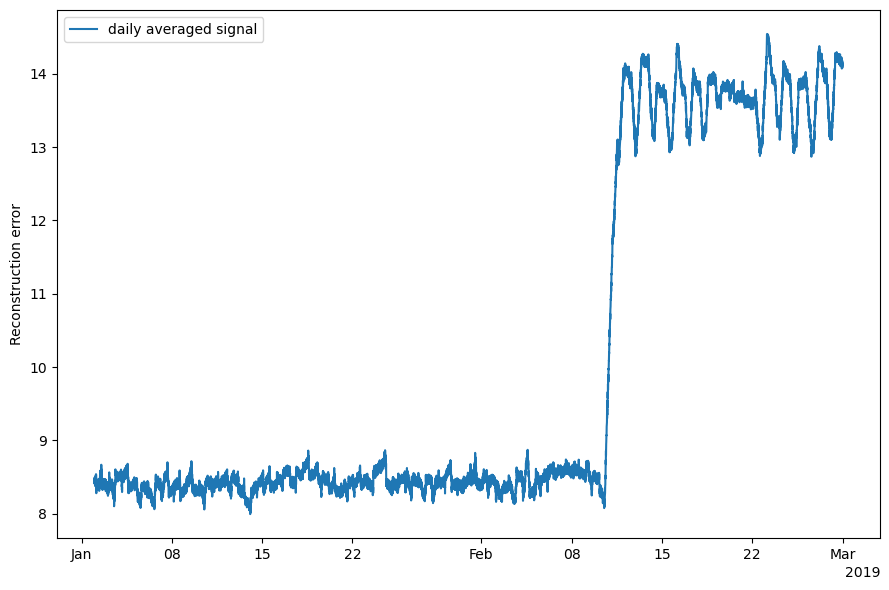

In [12]:
node_MAS = 'n31'
closest_nodes = ['n4','n1']
pipe_id = 'p280'

tank_area = 16**2*math.pi/4
tank_level_change = (scada_data.levels['T1'].diff()) *12 #resolution correction from (l/5mins) to (l/h)
tank_flow = tank_level_change * tank_area
mass_balance_DMA_C = pd.concat([scada_data.flows['PUMP_1'],scada_data.demands.sum(axis=1)/1000*-1,tank_flow*-1], axis=1).sum(axis=1).rolling('D').mean().loc['2019-01-02':'2019-02']

f,ax = plt.subplots(1,sharex=True,figsize=(9,6))
locator = mdates.AutoDateLocator(minticks=7, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
formatter.offset_formats[2] = '%Y'
ax.get_xaxis().set_major_locator(locator)
ax.get_xaxis().set_major_formatter(formatter)

ax.plot(mass_balance_DMA_C, label='daily averaged signal')

ax.legend(loc=0)
ax.set_ylabel('Reconstruction error')
f.tight_layout()
plt.show()

trajectories[pipe_id] = mass_balance_DMA_C

### Leak 4

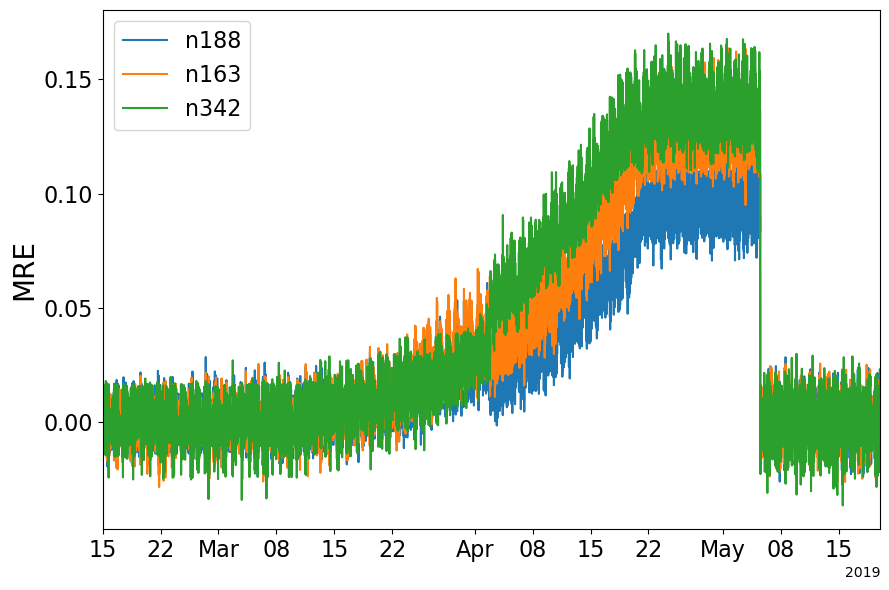

In [13]:
node_MAS = 'n613'
closest_nodes = ['n188','n163','n342']
pipe_id = 'p653'

time_frame_list = [['2019-02-15 00:00','2019-01-05 00:00','2019-01-09 00:00','2019-04-02 20:35'],
                   ['2019-04-02 20:40','2019-05-08 00:00','2019-05-15 00:00','2019-05-20 00:00']]
leak_analysis_individual()

### Leak 5

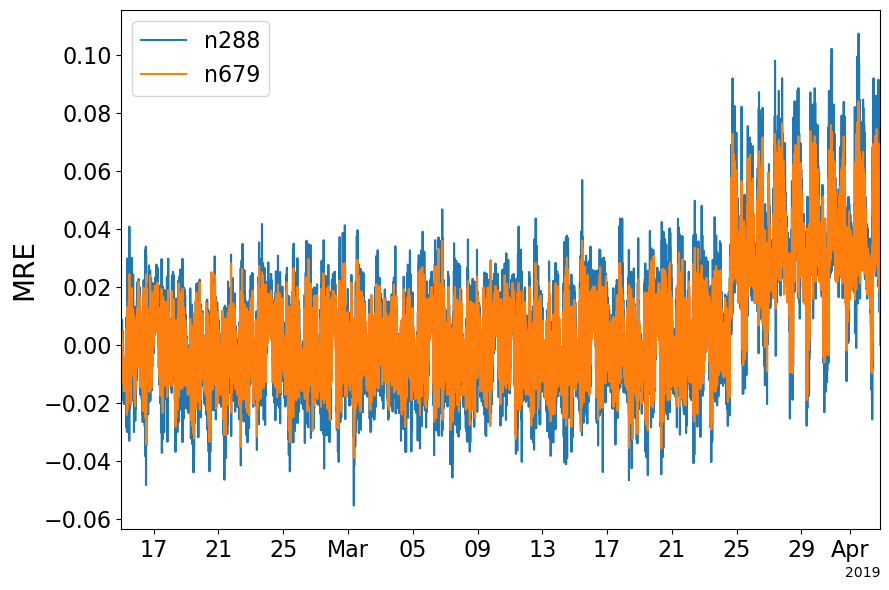

In [14]:
node_MAS = 'n644'
closest_nodes = ['n288','n679']
pipe_id = 'p710'

time_frame_list = [['2019-02-15 00:00','2019-03-10 00:00','2019-03-19 00:00','2019-04-02 20:35']]
leak_analysis_individual()

### Leak 6

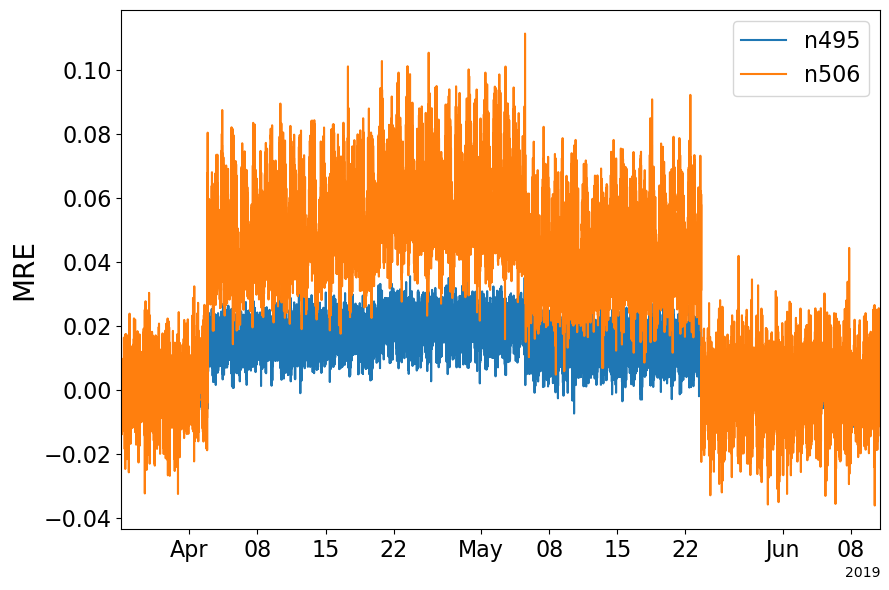

In [15]:
node_MAS = 'n332'
closest_nodes = ['n495','n506']
pipe_id = 'p514'

time_frame_list = [['2019-03-25 00:00','2019-03-27 00:00','2019-03-31 00:00','2019-04-20 14:20'],
                   ['2019-04-20 14:25','2019-05-25 00:00','2019-05-30 00:00','2019-06-10 23:55']]
leak_analysis_individual()

### Leak 7

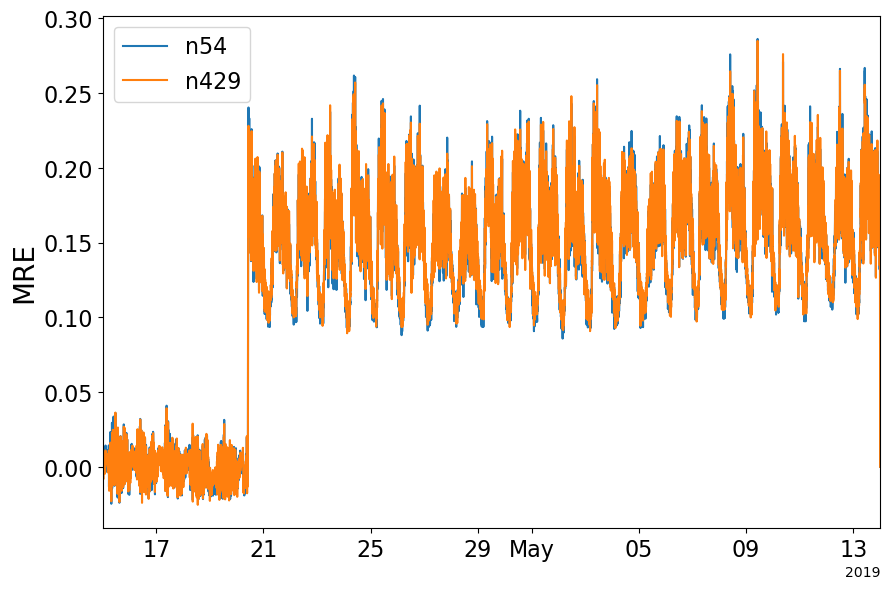

In [16]:
node_MAS = 'n410'
closest_nodes = ['n54','n429']
pipe_id = 'p331'

time_frame_list = [['2019-04-15 00:00','2019-04-15 00:00','2019-04-20 00:00','2019-05-14 00:00']]
leak_analysis_individual()

### Leak 8

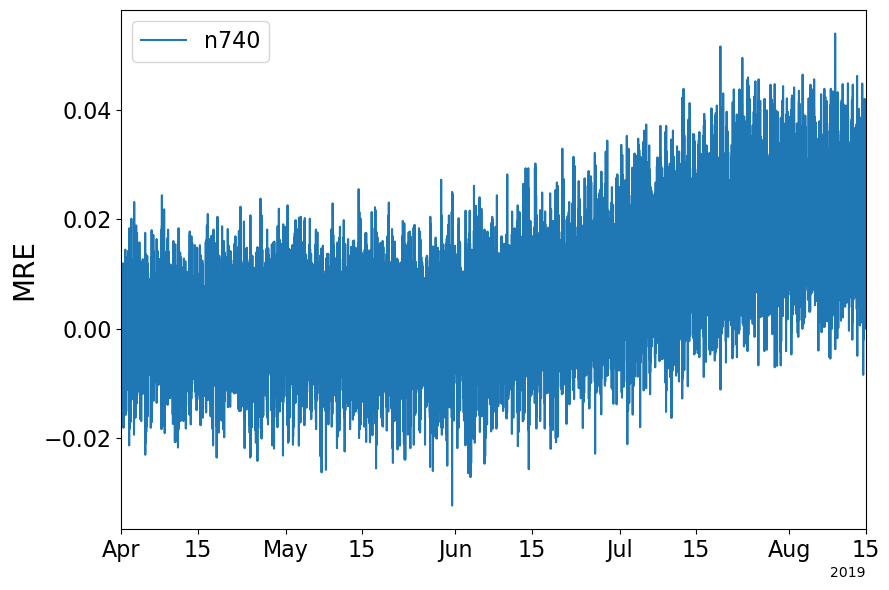

In [17]:
node_MAS = 'n752'
closest_nodes = ['n740']
pipe_id = 'p193'

time_frame_list = [['2019-04-01 00:00','2019-04-01 00:00','2019-05-09 00:00','2019-08-15 00:00']]
leak_analysis_individual()

### Leak 9

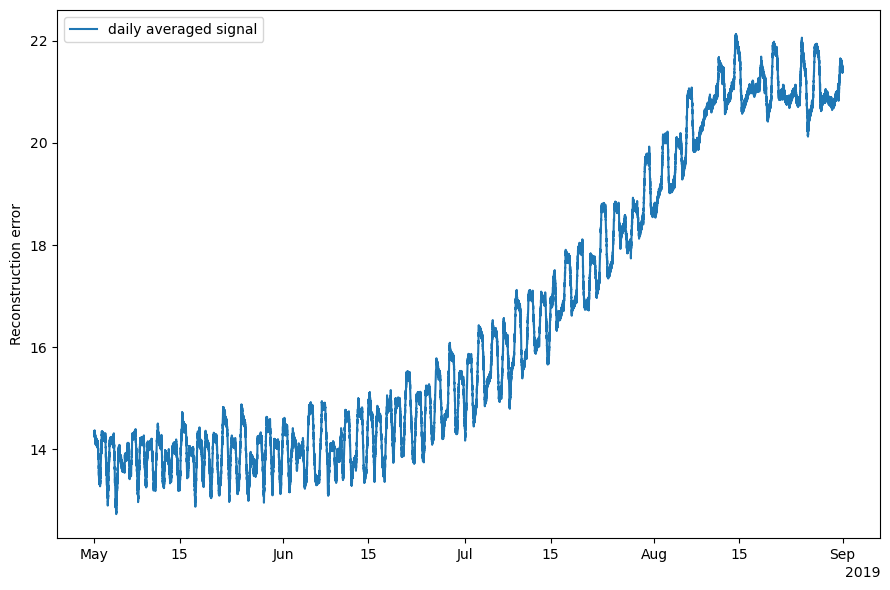

In [18]:
node_MAS = 'n31'
closest_nodes = ['n4','n1']
pipe_id = 'p277'

tank_area = 16**2*math.pi/4
tank_level_change = (scada_data.levels['T1'].diff()) *12
tank_flow = tank_level_change * tank_area
mass_balance_DMA_C = pd.concat([scada_data.flows['PUMP_1'],scada_data.demands.sum(axis=1)/1000*-1,tank_flow*-1], axis=1).sum(axis=1).rolling('D').mean().loc['2019-05':'2019-08']

f,ax = plt.subplots(1,sharex=True,figsize=(9,6))
locator = mdates.AutoDateLocator(minticks=7, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
formatter.offset_formats[2] = '%Y'
ax.get_xaxis().set_major_locator(locator)
ax.get_xaxis().set_major_formatter(formatter)

ax.plot(mass_balance_DMA_C, label='daily averaged signal')

ax.legend(loc=0)
ax.set_ylabel('Reconstruction error')
f.tight_layout()
plt.show()

trajectories[pipe_id] = mass_balance_DMA_C

### Leak 10

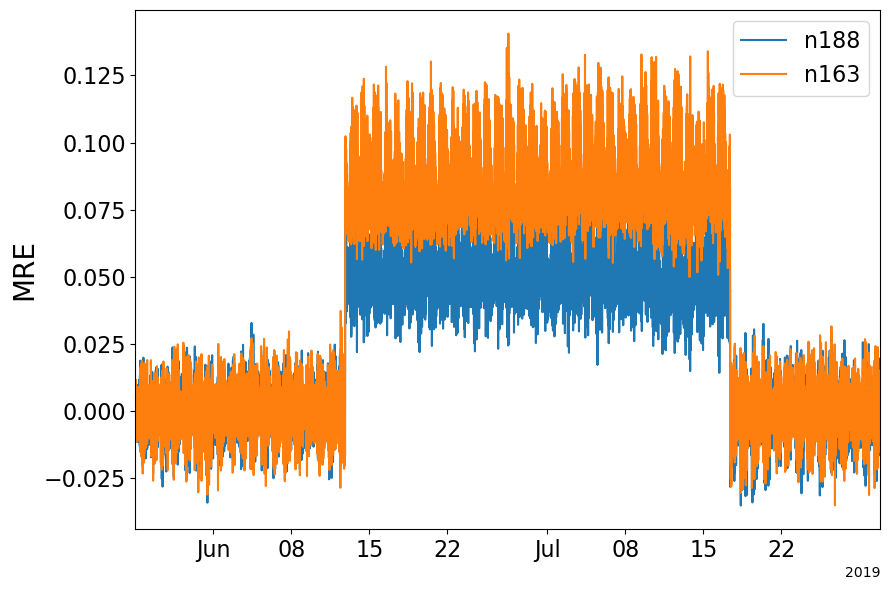

In [19]:
node_MAS = 'n613'
closest_nodes = ['n188','n163']
pipe_id = 'p142'

time_frame_list = [['2019-05-25 00:00','2019-05-30 00:00','2019-06-05 00:00','2019-07-10 10:10'],
                   ['2019-07-10 10:10','2019-07-22 00:00','2019-07-24 00:00','2019-07-30 20:30']]
leak_analysis_individual()

### Leak 11

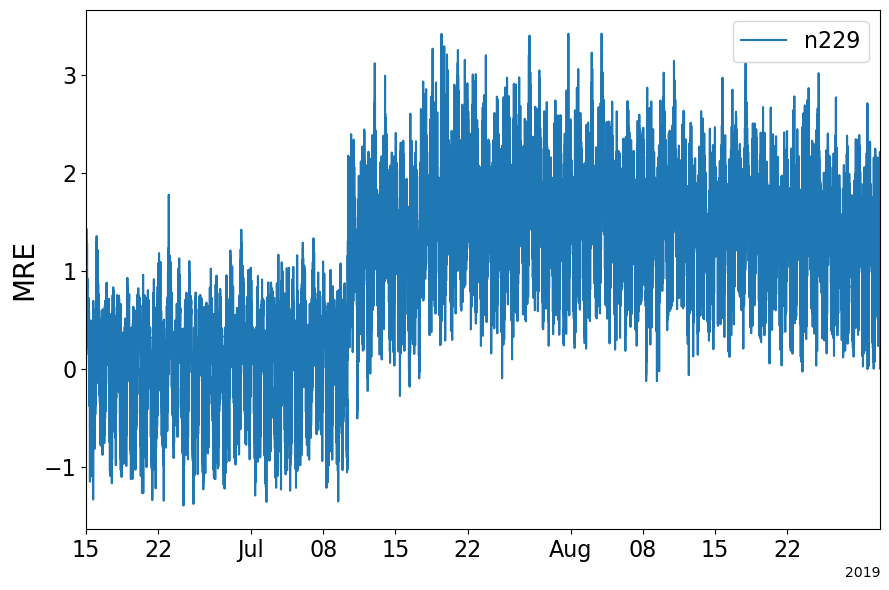

In [20]:
node_MAS = 'n215'
closest_nodes = ['n229']
pipe_id = 'p680'

time_frame_list = [['2019-06-15 00:00','2019-06-15 00:00','2019-06-30 00:00','2019-08-31 00:00']]
leak_analysis_individual()

### Leak 12

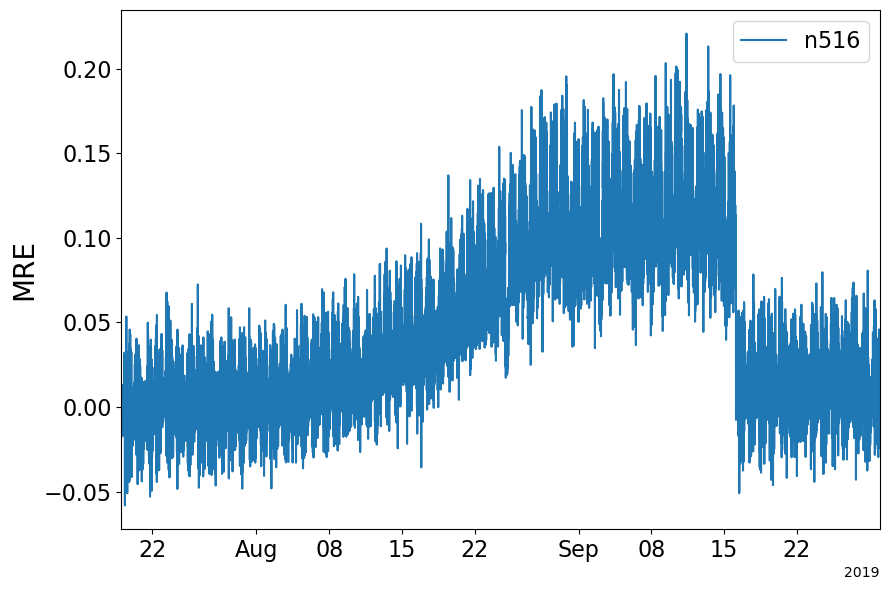

In [21]:
node_MAS = 'n549'
closest_nodes = ['n516']
pipe_id = 'p586'

time_frame_list = [['2019-07-19 00:00','2019-07-19 00:00','2019-07-25 00:00','2019-09-30 00:00']]
leak_analysis_individual()

### Leak 13

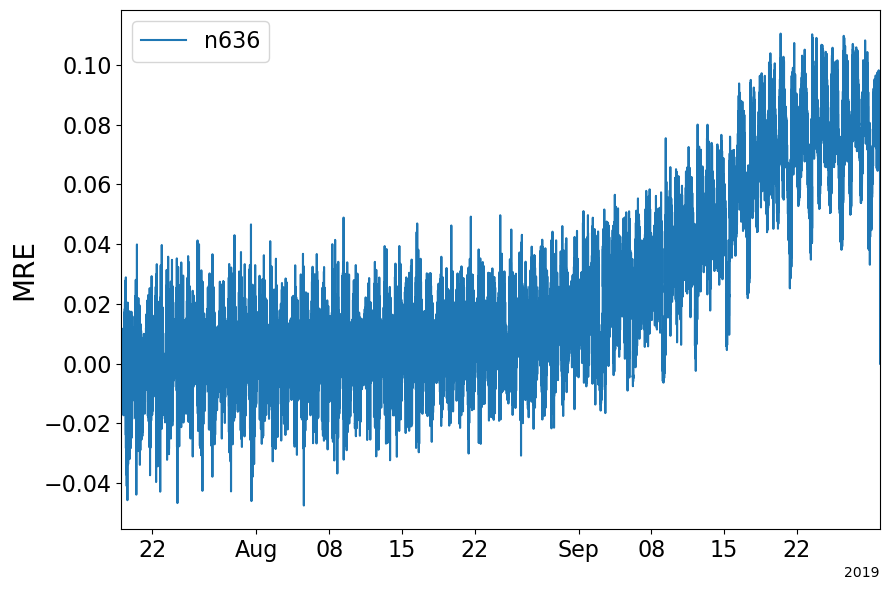

In [22]:
node_MAS = 'n644'
closest_nodes = ['n636']
pipe_id = 'p721'

time_frame_list = [['2019-07-19 00:00','2019-07-19 00:00','2019-07-25 00:00','2019-09-30 00:00']]
leak_analysis_individual()

### Leak 14

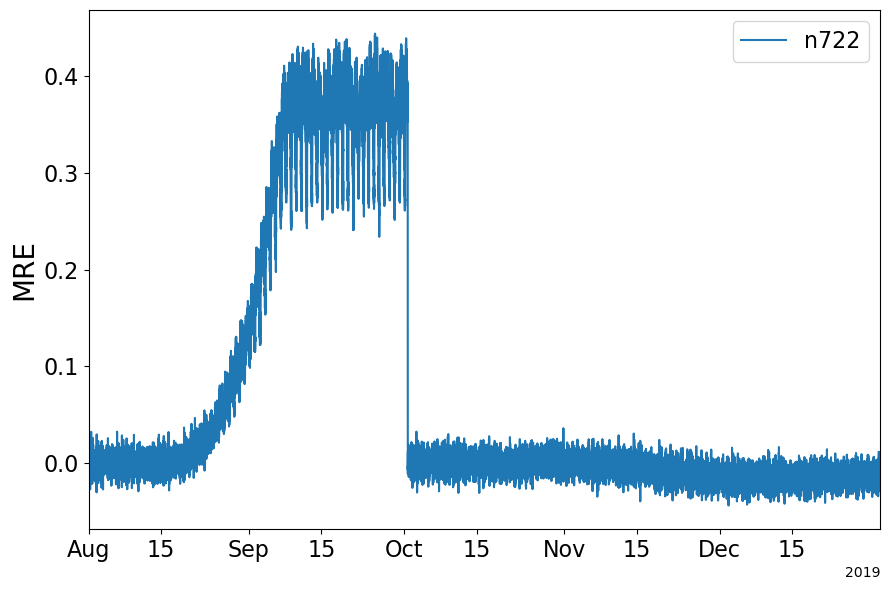

In [23]:
node_MAS = 'n296'
closest_nodes = ['n722']
pipe_id = 'p800'

time_frame_list = [['2019-08-01 00:00','2019-08-01 00:00','2019-08-09 00:00','2019-09-16 03:20'],
                   ['2019-09-16 03:20','2019-10-05 00:00','2019-10-09 00:00','2019-12-31 23:55']]
leak_analysis_individual()

### Leak 15

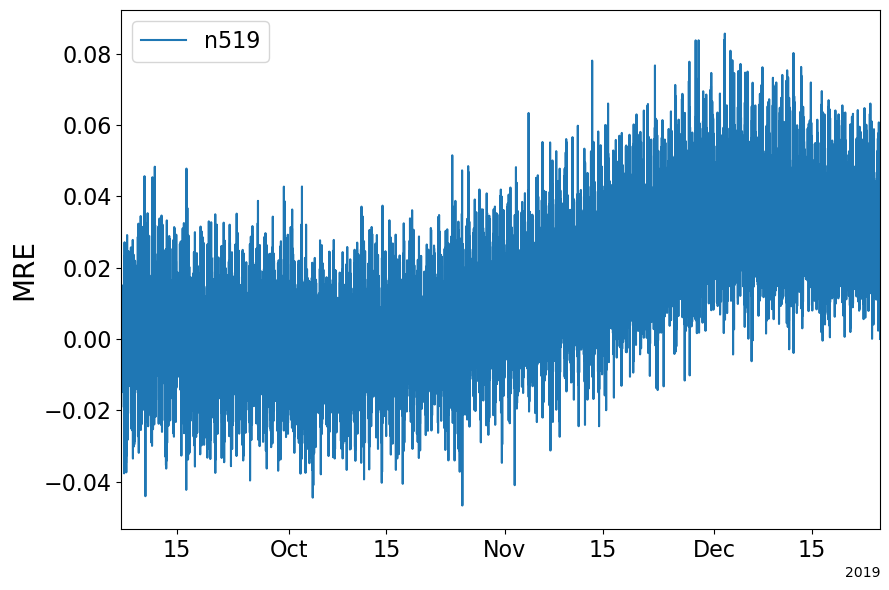

In [24]:
node_MAS = 'n163'
closest_nodes = ['n519']
pipe_id = 'p123'

time_frame_list = [['2019-09-07 00:00','2019-09-07 00:00','2019-09-12 00:00','2019-12-24 18:25']]
leak_analysis_individual()

### Leak 16

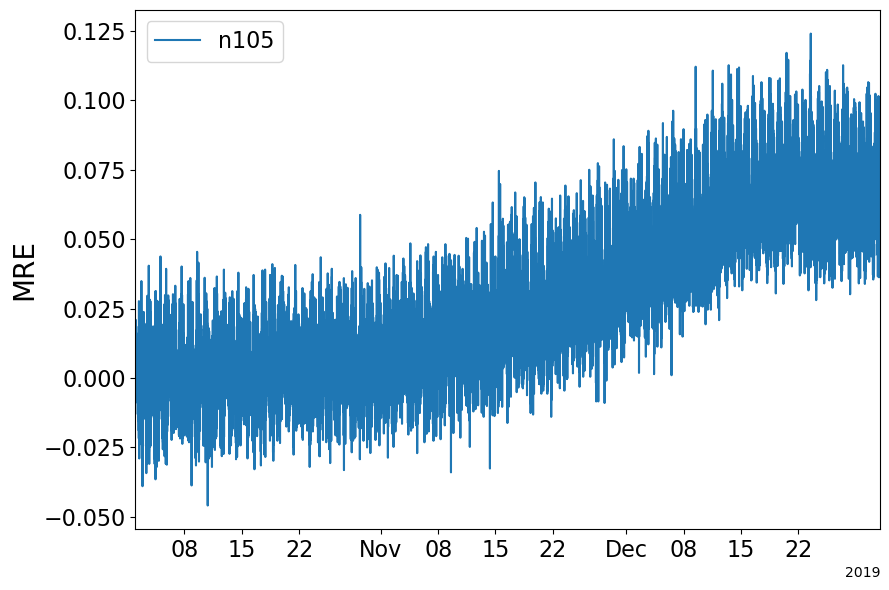

In [25]:
node_MAS = 'n114'
closest_nodes = ['n105']
pipe_id = 'p455'

time_frame_list = [['2019-10-02 00:00','2019-10-02 00:00','2019-10-05 00:00','2019-12-31 23:55']]
leak_analysis_individual()

### Leak 17

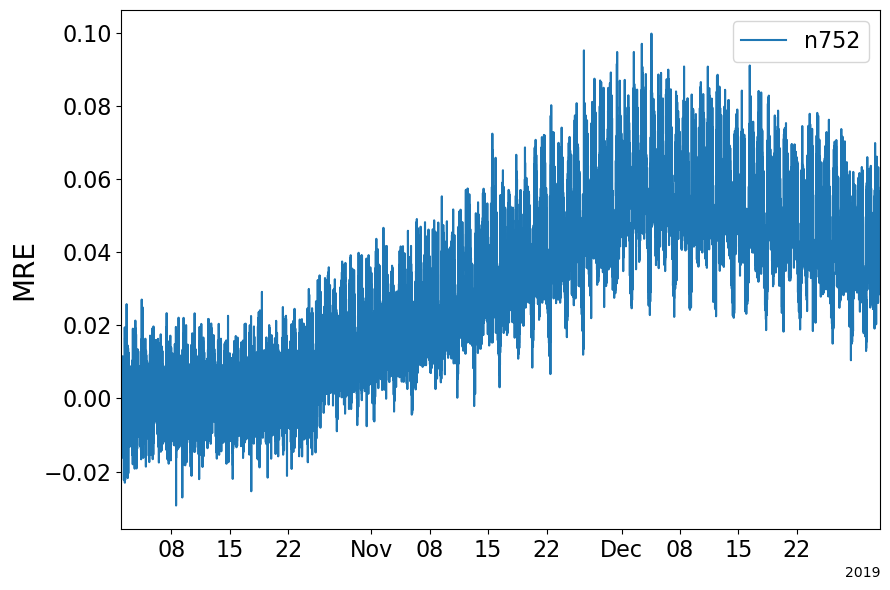

In [26]:
node_MAS = 'n288'
closest_nodes = ['n752']
pipe_id = 'p762'

time_frame_list = [['2019-10-02 00:00','2019-10-02 00:00','2019-10-05 00:00','2019-12-31 23:55']]
leak_analysis_individual()

### Leak 18

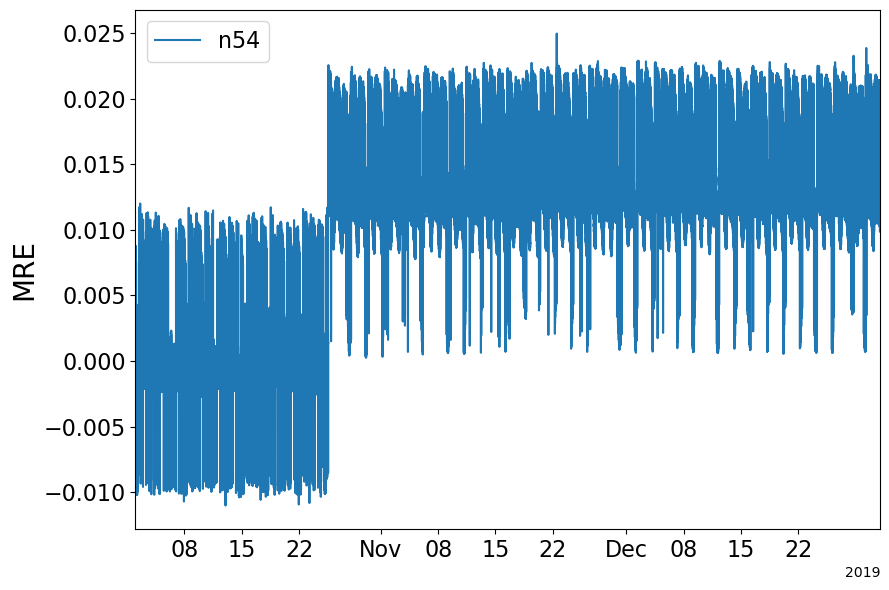

In [27]:
node_MAS = 'n429'
closest_nodes = ['n54']
pipe_id = 'p426'

time_frame_list = [['2019-10-02 00:00','2019-10-02 00:00','2019-10-05 00:00','2019-12-31 23:55']]
leak_analysis_individual()

### Leak 19

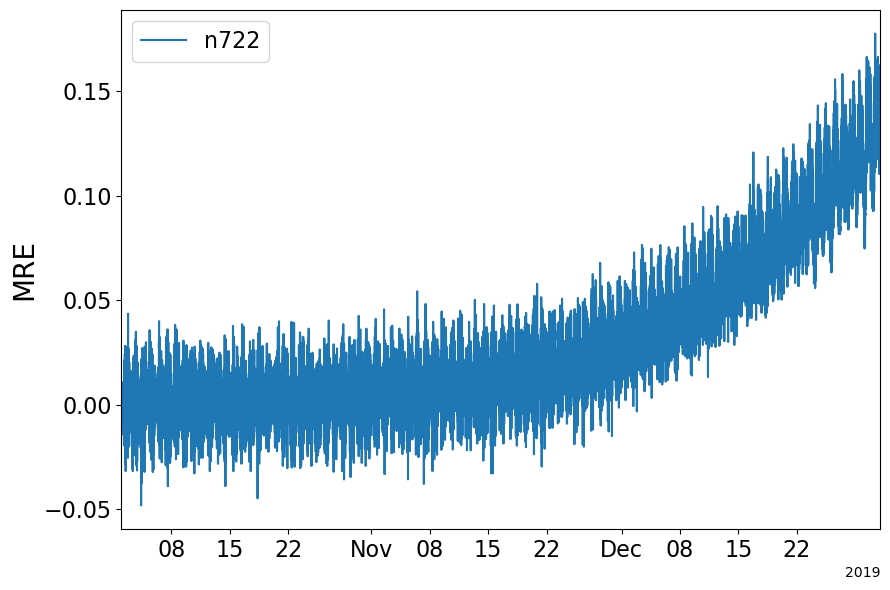

In [28]:
node_MAS = 'n769'
closest_nodes = ['n722']
pipe_id = 'p879'

time_frame_list = [['2019-10-02 00:00','2019-10-02 00:00','2019-10-09 00:00','2019-12-31 23:55']]
leak_analysis_individual()

### Summary of single leakages in DMA A

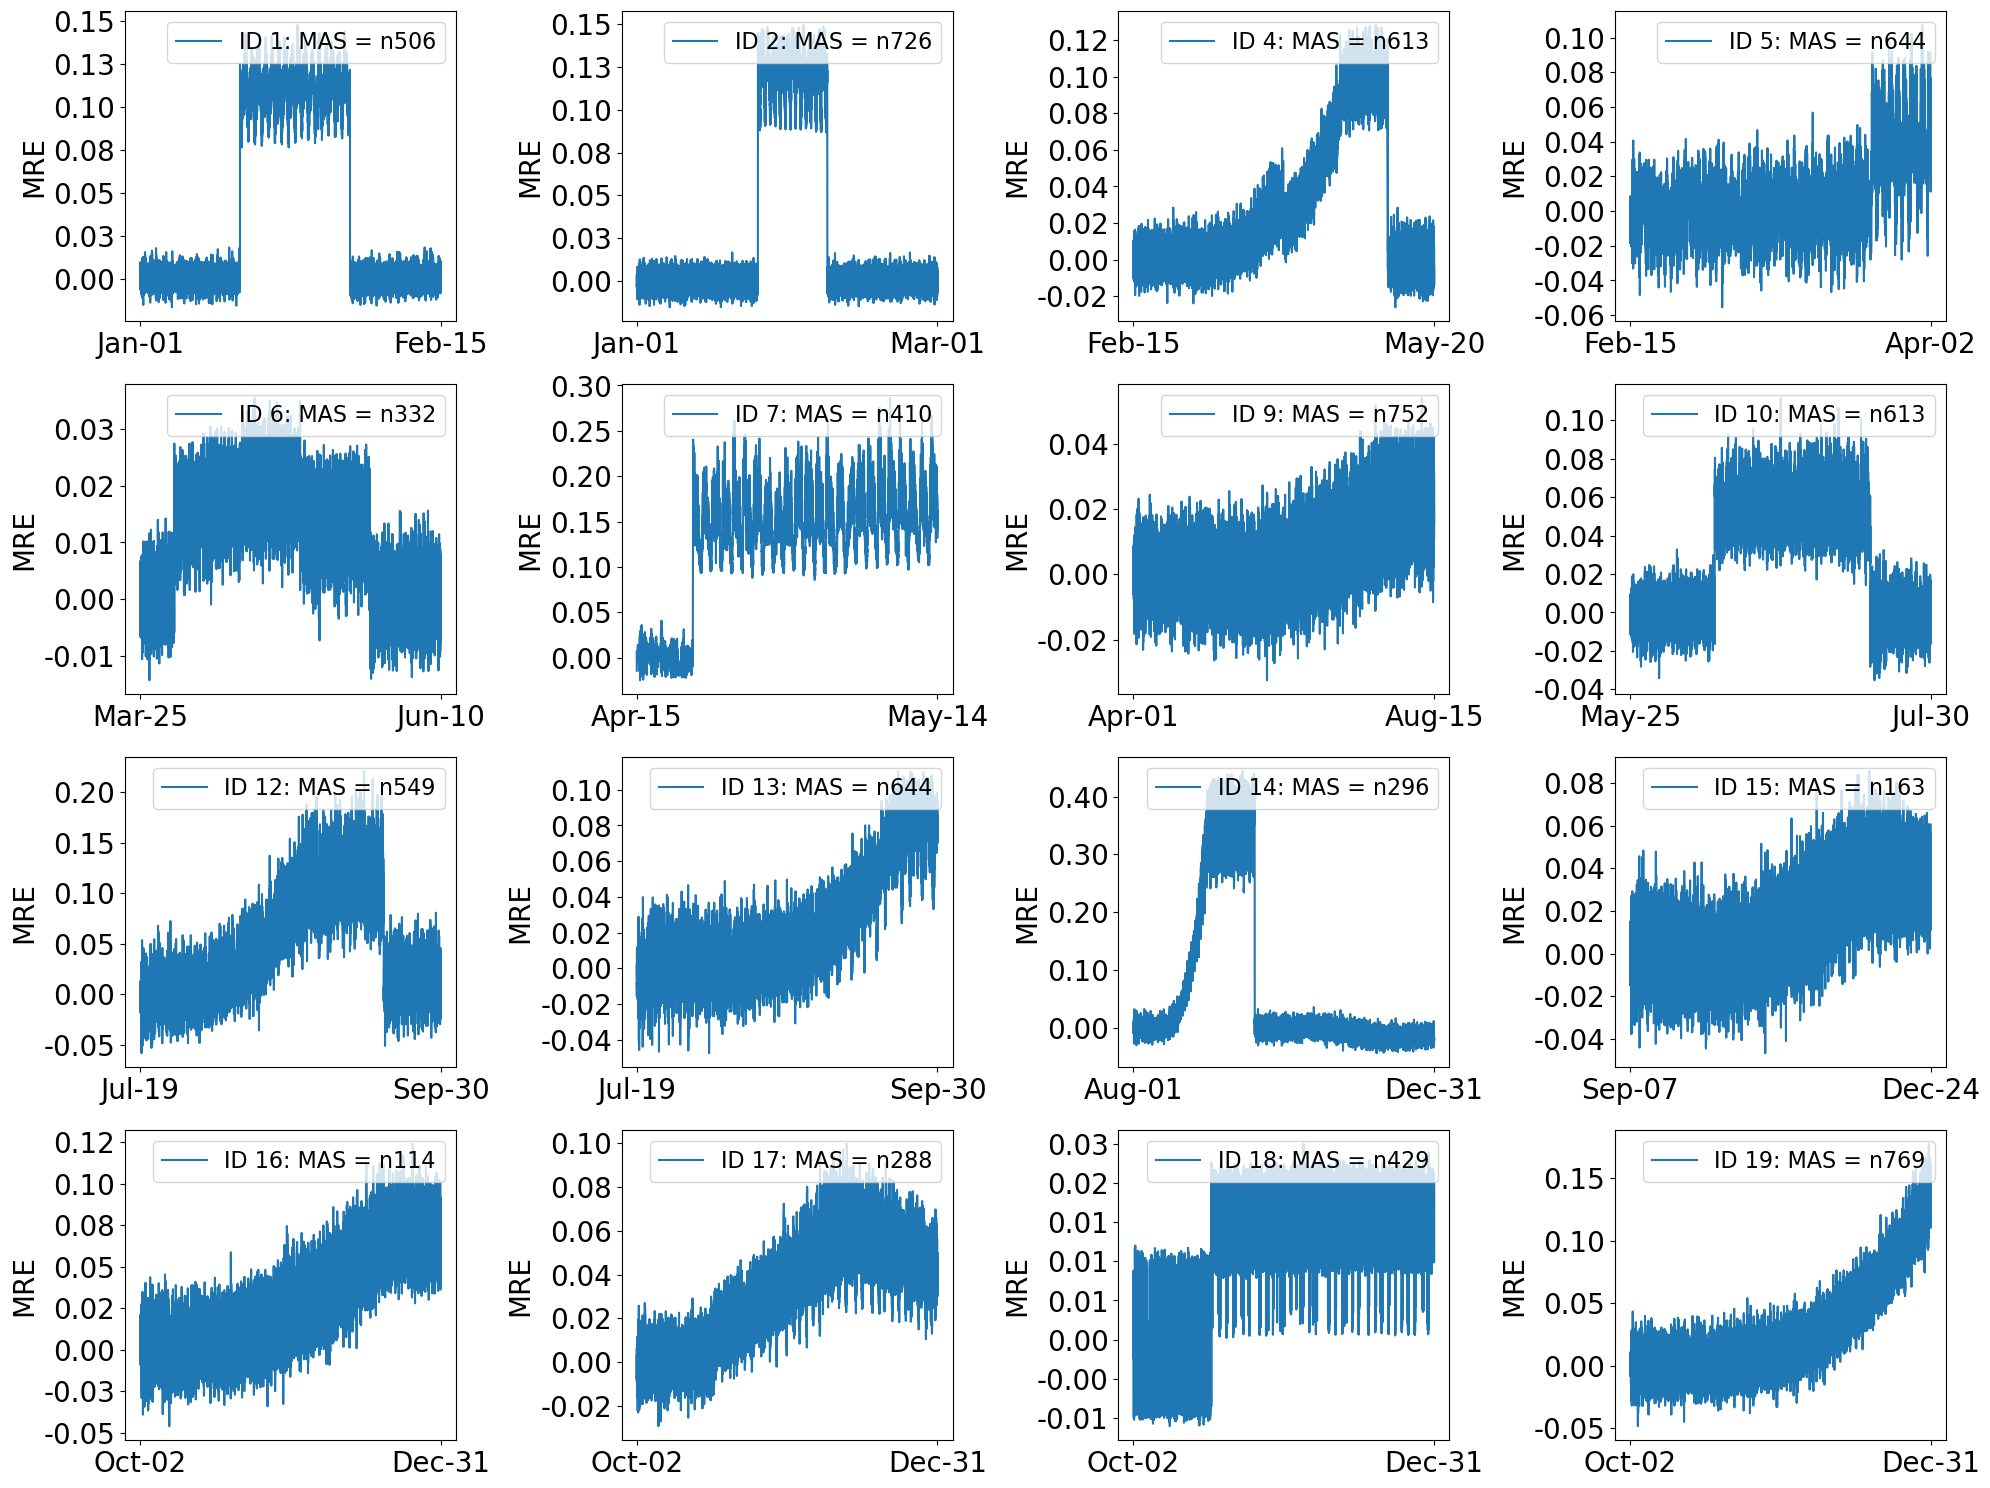

In [29]:
plt.style.use(['default'])
f,ax = plt.subplots(4,4,sharex=False,sharey=False,figsize=(20,15))
locator = mdates.AutoDateLocator(minticks=2, maxticks=4)
formatter = mdates.ConciseDateFormatter(locator)
#formatter.offset_formats[2] = '%Y'

ax[0,0].plot(trajectories['p523'][trajectories['p523']!=0],label='ID {}: MAS = {}'.format('1','n506'))
ax[0,0].set_xticks([pd.to_datetime(trajectories['p523'][trajectories['p523']!=0].index[0]),
                    pd.to_datetime(trajectories['p523'][trajectories['p523']!=0].index[-1])])
ax[0,1].plot(trajectories['p827'][trajectories['p827']!=0],label='ID {}: MAS = {}'.format('2','n726'))
ax[0,1].set_xticks([pd.to_datetime(trajectories['p827'][trajectories['p827']!=0].index[0]),
                    pd.to_datetime(trajectories['p827'][trajectories['p827']!=0].index[-1])])
ax[0,2].plot(trajectories['p653'][trajectories['p653']!=0],label='ID {}: MAS = {}'.format('4','n613'))
ax[0,2].set_xticks([pd.to_datetime(trajectories['p653'][trajectories['p653']!=0].index[0]),
                    pd.to_datetime(trajectories['p653'][trajectories['p653']!=0].index[-1])])
ax[0,3].plot(trajectories['p710'][trajectories['p710']!=0],label='ID {}: MAS = {}'.format('5','n644'))
ax[0,3].set_xticks([pd.to_datetime(trajectories['p710'][trajectories['p710']!=0].index[0]),
                    pd.to_datetime(trajectories['p710'][trajectories['p710']!=0].index[-1])])

ax[1,0].plot(trajectories['p514'][trajectories['p514']!=0],label='ID {}: MAS = {}'.format('6','n332'))
ax[1,0].set_xticks([pd.to_datetime(trajectories['p514'][trajectories['p514']!=0].index[0]),
                    pd.to_datetime(trajectories['p514'][trajectories['p514']!=0].index[-1])])
ax[1,1].plot(trajectories['p331'][trajectories['p331']!=0],label='ID {}: MAS = {}'.format('7','n410'))
ax[1,1].set_xticks([pd.to_datetime(trajectories['p331'][trajectories['p331']!=0].index[0]),
                    pd.to_datetime(trajectories['p331'][trajectories['p331']!=0].index[-1])])
ax[1,2].plot(trajectories['p193'][trajectories['p193']!=0],label='ID {}: MAS = {}'.format('9','n752'))
ax[1,2].set_xticks([pd.to_datetime(trajectories['p193'][trajectories['p193']!=0].index[0]),
                    pd.to_datetime(trajectories['p193'][trajectories['p193']!=0].index[-1])])
ax[1,3].plot(trajectories['p142'][trajectories['p142']!=0],label='ID {}: MAS = {}'.format('10','n613'))
ax[1,3].set_xticks([pd.to_datetime(trajectories['p142'][trajectories['p142']!=0].index[0]),
                    pd.to_datetime(trajectories['p142'][trajectories['p142']!=0].index[-1])])

ax[2,0].plot(trajectories['p586'][trajectories['p586']!=0],label='ID {}: MAS = {}'.format('12','n549'))
ax[2,0].set_xticks([pd.to_datetime(trajectories['p586'][trajectories['p586']!=0].index[0]),
                    pd.to_datetime(trajectories['p586'][trajectories['p586']!=0].index[-1])])
ax[2,1].plot(trajectories['p721'][trajectories['p721']!=0],label='ID {}: MAS = {}'.format('13','n644'))
ax[2,1].set_xticks([pd.to_datetime(trajectories['p721'][trajectories['p721']!=0].index[0]),
                    pd.to_datetime(trajectories['p721'][trajectories['p721']!=0].index[-1])])
ax[2,2].plot(trajectories['p800'][trajectories['p800']!=0],label='ID {}: MAS = {}'.format('14','n296'))
ax[2,2].set_xticks([pd.to_datetime(trajectories['p800'][trajectories['p800']!=0].index[0]),
                    pd.to_datetime(trajectories['p800'][trajectories['p800']!=0].index[-1])])
ax[2,3].plot(trajectories['p123'][trajectories['p123']!=0],label='ID {}: MAS = {}'.format('15','n163'))
ax[2,3].set_xticks([pd.to_datetime(trajectories['p123'][trajectories['p123']!=0].index[0]),
                    pd.to_datetime(trajectories['p123'][trajectories['p123']!=0].index[-1])])

ax[3,0].plot(trajectories['p455'][trajectories['p455']!=0],label='ID {}: MAS = {}'.format('16','n114'))
ax[3,0].set_xticks([pd.to_datetime(trajectories['p455'][trajectories['p455']!=0].index[0]),
                    pd.to_datetime(trajectories['p455'][trajectories['p455']!=0].index[-1])])
ax[3,1].plot(trajectories['p762'][trajectories['p762']!=0],label='ID {}: MAS = {}'.format('17','n288'))
ax[3,1].set_xticks([pd.to_datetime(trajectories['p762'][trajectories['p762']!=0].index[0]),
                    pd.to_datetime(trajectories['p762'][trajectories['p762']!=0].index[-1])])
ax[3,2].plot(trajectories['p426'][trajectories['p426']!=0],label='ID {}: MAS = {}'.format('18','n429'))
ax[3,2].set_xticks([pd.to_datetime(trajectories['p426'][trajectories['p426']!=0].index[0]),
                    pd.to_datetime(trajectories['p426'][trajectories['p426']!=0].index[-1])])
ax[3,3].plot(trajectories['p879'][trajectories['p879']!=0],label='ID {}: MAS = {}'.format('19','n769'))
ax[3,3].set_xticks([pd.to_datetime(trajectories['p879'][trajectories['p879']!=0].index[0]),
                    pd.to_datetime(trajectories['p879'][trajectories['p879']!=0].index[-1])])

for ax1 in ax:
    for ax2 in ax1:
        ax2.legend(loc=1,prop={'size':16})
        ax2.set_ylabel('MRE',fontsize=20)
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        #ax2.xaxis.set_major_locator(ticker.MultipleLocator(25))
        for tick in ax2.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        for tick in ax2.yaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
f.tight_layout()
plt.show()

# Results: save to file

In [30]:
trajectories.to_csv('../_utils/Data/leak_detections/Leakages_detected.csv')